In [1]:
# ===============================
# Imports & Setup (Colab-ready)
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# ===============================
# File paths (Colab)
# ===============================
DATA_DIR = "/content"

RIPPLE_CSV = os.path.join(DATA_DIR, "alu_data_ripple_16bit.csv")
CLA_CSV    = os.path.join(DATA_DIR, "alu_data_cla_16bit.csv")
LP_CSV     = os.path.join(DATA_DIR, "alu_data_lp_16bit.csv")

In [3]:
# ===============================
# Load & merge data
# ===============================
def load_and_merge():
    df_ripple = pd.read_csv(RIPPLE_CSV)
    df_cla    = pd.read_csv(CLA_CSV)
    df_lp     = pd.read_csv(LP_CSV)

    df = pd.concat([df_ripple, df_cla, df_lp], ignore_index=True)

    # ✅ Normalize enable signal
    # Ripple & CLA → always enabled
    # LP → en already present (0/1)
    if "en" in df.columns:
        df["en"] = df["en"].fillna(1)
    else:
        df["en"] = 1

    return df

In [4]:
# ===============================
# Synthetic power label
# ===============================
def add_power_label(df):
    base_scale = {0: 1.0, 1: 1.25, 2: 0.6}  # ripple, CLA, LP
    df["alu_scale"] = df["alu_id"].astype(int).map(base_scale)

    activity = (
        0.8 * df["y_toggles"] +
        0.1 * df["a_hw"] +
        0.1 * df["b_hw"]
    )

    df["power"] = df["alu_scale"] * activity * df["en"]

    # Small noise (realistic)
    noise = np.random.normal(
        0, df["power"].std() * 0.02, size=len(df)
    )
    df["power"] += noise

    return df

In [5]:
# ===============================
# Feature matrix
# ===============================
def build_features(df):
    # Base features
    feature_cols = [
        "alu_id",
        "opcode",
        "a_hw",
        "b_hw",
        "y_toggles",
        "en"
    ]

    # Add interaction features for 'en' signal
    # This helps linear models capture the multiplicative effect of 'en'
    df["toggles_x_en"] = df["y_toggles"] * df["en"]
    df["a_hw_x_en"] = df["a_hw"] * df["en"]
    df["b_hw_x_en"] = df["b_hw"] * df["en"]

    feature_cols.extend(["toggles_x_en", "a_hw_x_en", "b_hw_x_en"])

    X = df[feature_cols].values
    y = df["power"].values
    return X, y, feature_cols

In [6]:
# ===============================
# Train & evaluate models
# ===============================
def train_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.01),
        "Random Forest": RandomForestRegressor(
            n_estimators=200,
            random_state=RANDOM_SEED,
            n_jobs=-1
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=150,
            random_state=RANDOM_SEED
        ),
    }

    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results[name] = {"MAE": mae, "RMSE": rmse}
        predictions[name] = y_pred

    return results, predictions, models

In [7]:
# ===============================
# Plot: Model comparison
# ===============================
def plot_model_comparison(results):
    labels = list(results.keys())
    mae_vals = [results[k]["MAE"] for k in labels]
    rmse_vals = [results[k]["RMSE"] for k in labels]

    colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.bar(labels, mae_vals, color=colors)
    plt.ylabel("MAE")
    plt.title("Model Comparison – MAE")
    plt.xticks(rotation=30)

    plt.subplot(1,2,2)
    plt.bar(labels, rmse_vals, color=colors)
    plt.ylabel("RMSE")
    plt.title("Model Comparison – RMSE")
    plt.xticks(rotation=30)

    plt.tight_layout()
    plt.show()

In [8]:
# ===============================
# Plot: True vs Predicted (ALL MODELS)
# ===============================
def plot_true_vs_pred_combined(y_actual, predictions_dict):
    plt.figure(figsize=(7,7))

    colors = plt.cm.Paired(np.linspace(0, 1, len(predictions_dict)))

    for (name, y_pred), c in zip(predictions_dict.items(), colors):
        plt.scatter(
            y_actual, y_pred,
            s=30, alpha=0.6, label=name, color=c
        )

    mn = min([y_actual.min()] + [p.min() for p in predictions_dict.values()])
    mx = max([y_actual.max()] + [p.max() for p in predictions_dict.values()])
    plt.plot([mn, mx], [mn, mx], 'k--', linewidth=2, label="Ideal (y = x)")

    plt.xlabel("True Power")
    plt.ylabel("Predicted Power")
    plt.title("True vs Predicted Power — All Models")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# ===============================
# Plot: Prediction error spread
# ===============================
def plot_prediction_spread(y_actual, predictions_dict):
    plt.figure(figsize=(9,5))

    colors = plt.cm.Paired(np.linspace(0, 1, len(predictions_dict)))

    for (name, y_pred), c in zip(predictions_dict.items(), colors):
        error = y_pred - y_actual
        plt.scatter(
            y_actual, error,
            s=30, alpha=0.6, label=name, color=c
        )

    plt.axhline(0, color="black", linewidth=2)
    plt.xlabel("True Power")
    plt.ylabel("Prediction Error (Pred − True)")
    plt.title("Prediction Error Distribution — All Models")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# ===============================
# Plot: Feature importance
# ===============================
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    order = np.argsort(importances)[::-1]

    plt.figure(figsize=(6,4))
    plt.bar(range(len(feature_names)), importances[order])
    plt.xticks(
        range(len(feature_names)),
        np.array(feature_names)[order],
        rotation=30
    )
    plt.ylabel("Importance")
    plt.title("Feature Importance (Random Forest)")
    plt.show()

In [14]:
# ===============================
# MAIN
# ===============================
df = load_and_merge()
print("Samples loaded:", len(df))

df = add_power_label(df)

# Clean NaNs AFTER normalization
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("Samples after cleaning:", len(df))

X, y, feature_names = build_features(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

results, predictions, models = train_models(
    X_train, X_test, y_train, y_test
)
print(f"Number of samples plotted in 'True vs Predicted Power' graph: {len(y)}")
df_ripple = pd.read_csv(RIPPLE_CSV)
na_ripple = df_ripple.isnull().sum().sum()
print(f"NaN values in {os.path.basename(RIPPLE_CSV)}: {na_ripple}")

df_cla = pd.read_csv(CLA_CSV)
na_cla = df_cla.isnull().sum().sum()
print(f"NaN values in {os.path.basename(CLA_CSV)}: {na_cla}")

df_lp = pd.read_csv(LP_CSV)
na_lp = df_lp.isnull().sum().sum()
print(f"NaN values in {os.path.basename(LP_CSV)}: {na_lp}")
# Re-load and merge data to get the original 1900 samples
df_investigate = load_and_merge()
print(f"Samples after loading and merging: {len(df_investigate)}")

# Add the power label
df_investigate = add_power_label(df_investigate)
print(f"Samples after adding power label: {len(df_investigate)}")

# Check for NaN values before dropping
na_counts = df_investigate.isnull().sum()
infinity_counts = df_investigate.isin([np.inf, -np.inf]).sum()

print("\nNaN values per column before dropna():")
print(na_counts[na_counts > 0])

print("\nInfinity values per column before dropna():")
print(infinity_counts[infinity_counts > 0])

# Filter rows where at least one NaN or Inf exists
rows_with_na_or_inf = df_investigate[
    df_investigate.isnull().any(axis=1) |
    df_investigate.isin([np.inf, -np.inf]).any(axis=1)
]
num_rows_to_drop = len(rows_with_na_or_inf)
print(f"\nNumber of rows with NaN or Inf values that would be dropped: {num_rows_to_drop}")

# Apply the cleaning steps as in the original code
df_cleaned = df_investigate.replace([np.inf, -np.inf], np.nan)
df_cleaned = df_cleaned.dropna()
print(f"Samples after cleaning (replace inf and dropna): {len(df_cleaned)}")

print("\n=== MODEL PERFORMANCE ===")
for k, v in results.items():
    print(f"{k:20s}  MAE={v['MAE']:.4f}  RMSE={v['RMSE']:.4f}")

# Predictions for FULL dataset (no truncation)
full_data_predictions = {}
for name, model in models.items():
    full_data_predictions[name] = model.predict(X)

Samples loaded: 1900
Samples after cleaning: 1898
Number of samples plotted in 'True vs Predicted Power' graph: 1898
NaN values in alu_data_ripple_16bit.csv: 6
NaN values in alu_data_cla_16bit.csv: 6
NaN values in alu_data_lp_16bit.csv: 0
Samples after loading and merging: 1900
Samples after adding power label: 1900

NaN values per column before dropna():
opcode       2
a            2
b            2
a_hw         2
b_hw         2
y_toggles    2
power        2
dtype: int64

Infinity values per column before dropna():
Series([], dtype: int64)

Number of rows with NaN or Inf values that would be dropped: 2
Samples after cleaning (replace inf and dropna): 1898

=== MODEL PERFORMANCE ===
Linear                MAE=0.7869  RMSE=1.2140
Ridge                 MAE=0.7884  RMSE=1.2141
Lasso                 MAE=0.8060  RMSE=1.2153
Random Forest         MAE=0.0872  RMSE=0.1259
Gradient Boosting     MAE=0.0705  RMSE=0.1224


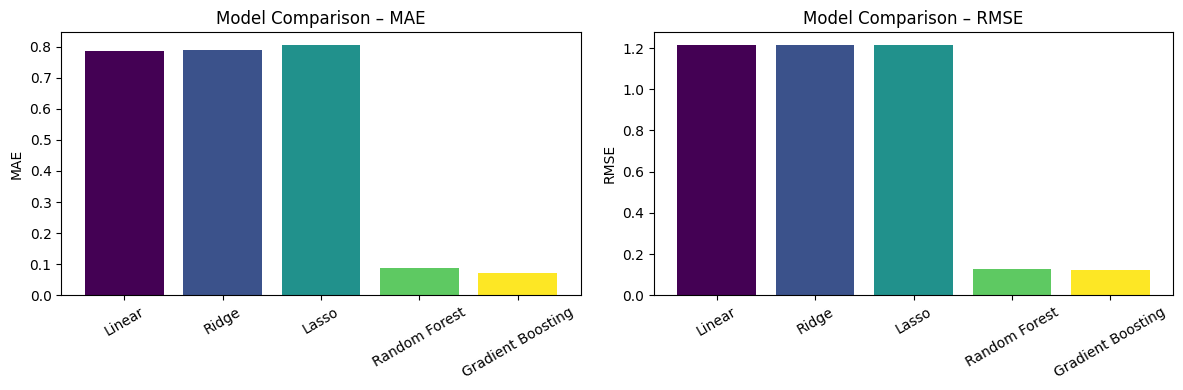

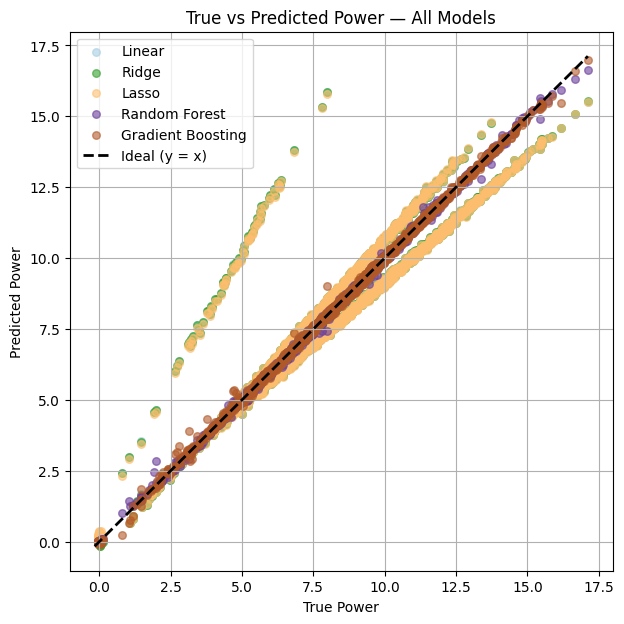

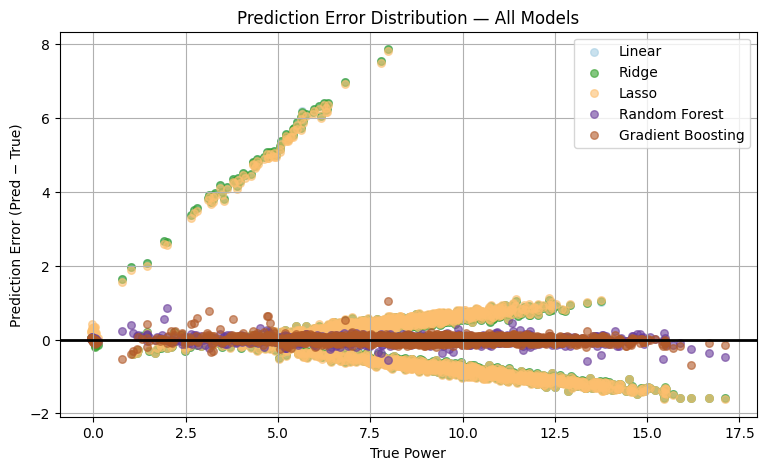

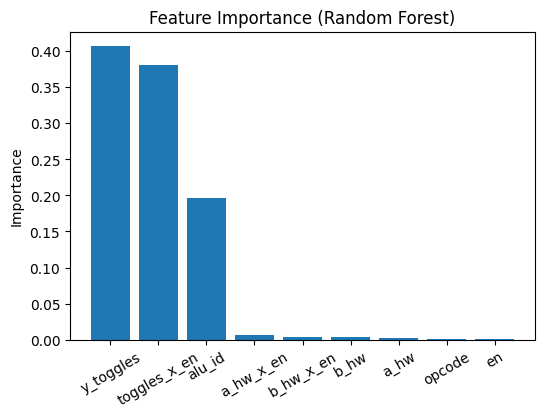

In [15]:
# ===============================
# ALL PLOTS
# ===============================
plot_model_comparison(results)
plot_true_vs_pred_combined(y, full_data_predictions)
plot_prediction_spread(y, full_data_predictions)
plot_feature_importance(models["Random Forest"], feature_names)

Samples loaded: 1900
Samples after cleaning: 1898

=== MODEL PERFORMANCE (on log-transformed target) ===
Linear                MAE=0.0978  RMSE=0.1565
Ridge                 MAE=0.0997  RMSE=0.1575
Lasso                 MAE=0.1172  RMSE=0.1615
Random Forest         MAE=0.0114  RMSE=0.0209
Gradient Boosting     MAE=0.0072  RMSE=0.0107


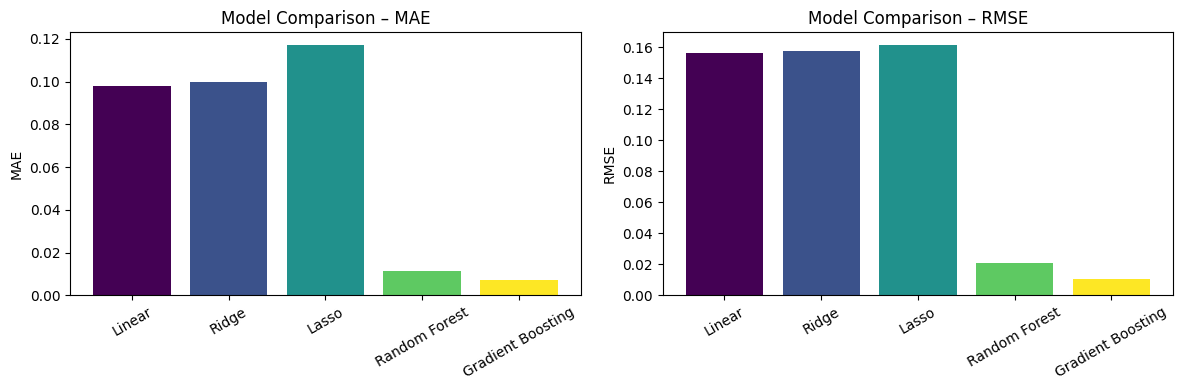

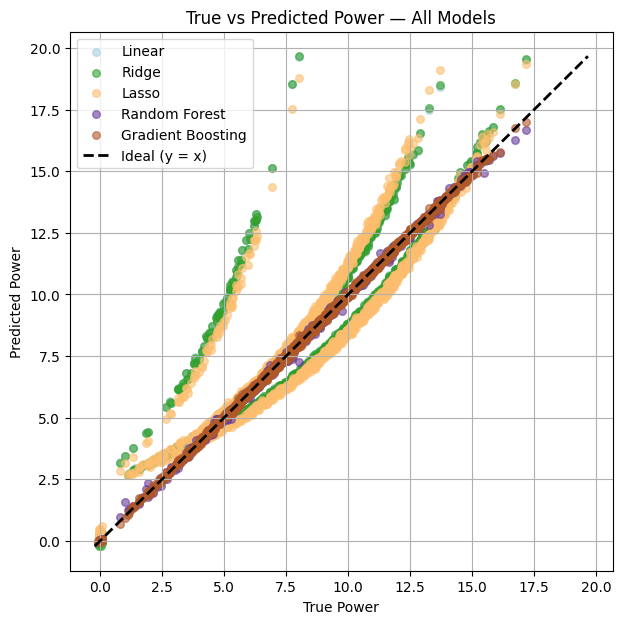

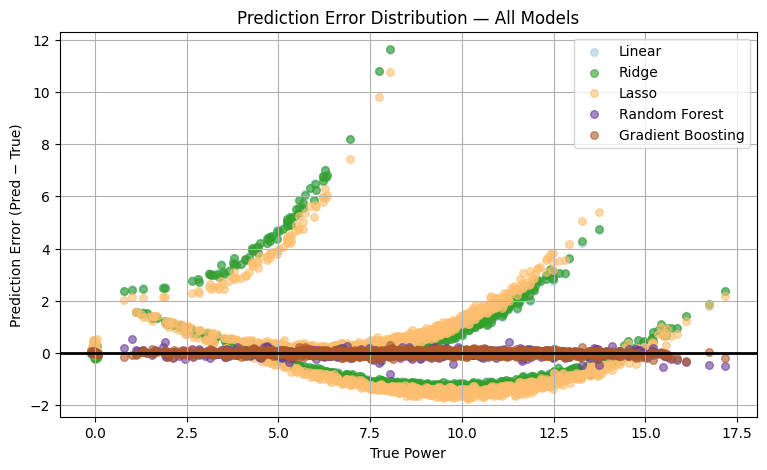

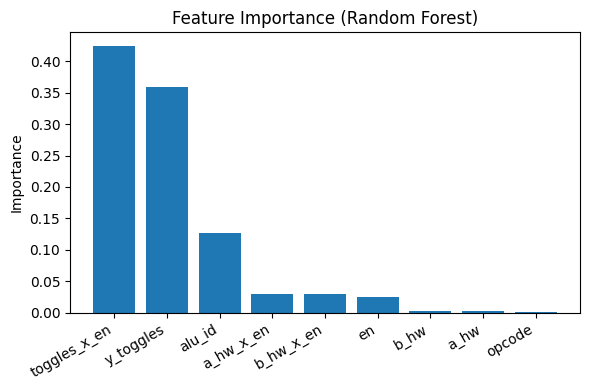

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ===============================
# File paths (Colab)
# ===============================
DATA_DIR = "/content"

RIPPLE_CSV = os.path.join(DATA_DIR, "alu_data_ripple_16bit.csv")
CLA_CSV    = os.path.join(DATA_DIR, "alu_data_cla_16bit.csv")
LP_CSV     = os.path.join(DATA_DIR, "alu_data_lp_16bit.csv")

# ===============================
# Load & merge data
# ===============================
def load_and_merge():
    df_ripple = pd.read_csv(RIPPLE_CSV)
    df_cla    = pd.read_csv(CLA_CSV)
    df_lp     = pd.read_csv(LP_CSV)

    df = pd.concat([df_ripple, df_cla, df_lp], ignore_index=True)

    # ✅ Normalize enable signal
    # Ripple & CLA → always enabled
    # LP → en already present (0/1)
    if "en" in df.columns:
        df["en"] = df["en"].fillna(1)
    else:
        df["en"] = 1

    return df

# ===============================
# Synthetic power label
# ===============================
def add_power_label(df):
    base_scale = {0: 1.0, 1: 1.25, 2: 0.6}  # ripple, CLA, LP
    df["alu_scale"] = df["alu_id"].astype(int).map(base_scale)

    activity = (
        0.8 * df["y_toggles"] +
        0.1 * df["a_hw"] +
        0.1 * df["b_hw"]
    )

    df["power"] = df["alu_scale"] * activity * df["en"]

    # Small noise (realistic)
    noise = np.random.normal(
        0, df["power"].std() * 0.02, size=len(df)
    )
    df["power"] += noise

    return df

# ===============================
# Feature matrix
# ===============================
def build_features(df):
    # Base features
    feature_cols = [
        "alu_id",
        "opcode",
        "a_hw",
        "b_hw",
        "y_toggles",
        "en"
    ]

    # Add interaction features for 'en' signal
    # This helps linear models capture the multiplicative effect of 'en'
    df["toggles_x_en"] = df["y_toggles"] * df["en"]
    df["a_hw_x_en"] = df["a_hw"] * df["en"]
    df["b_hw_x_en"] = df["b_hw"] * df["en"]

    feature_cols.extend(["toggles_x_en", "a_hw_x_en", "b_hw_x_en"])

    X = df[feature_cols].values
    y = df["power"].values # This 'y' is the original power value
    return X, y, feature_cols

# ===============================
# Train & evaluate models
# ===============================
def train_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.01),
        "Random Forest": RandomForestRegressor(
            n_estimators=200,
            random_state=RANDOM_SEED,
            n_jobs=-1
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=150,
            random_state=RANDOM_SEED
        ),
    }

    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results[name] = {"MAE": mae, "RMSE": rmse}
        predictions[name] = y_pred

    return results, predictions, models

# ===============================
# Plot: Model comparison
# ===============================
def plot_model_comparison(results):
    labels = list(results.keys())
    mae_vals = [results[k]["MAE"] for k in labels]
    rmse_vals = [results[k]["RMSE"] for k in labels]

    colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.bar(labels, mae_vals, color=colors)
    plt.ylabel("MAE")
    plt.title("Model Comparison – MAE")
    plt.xticks(rotation=30)

    plt.subplot(1,2,2)
    plt.bar(labels, rmse_vals, color=colors)
    plt.ylabel("RMSE")
    plt.title("Model Comparison – RMSE")
    plt.xticks(rotation=30)

    plt.tight_layout()
    plt.show()

# ===============================
# Plot: True vs Predicted (ALL MODELS)
# ===============================
def plot_true_vs_pred_combined(y_actual, predictions_dict):
    plt.figure(figsize=(7,7))

    colors = plt.cm.Paired(np.linspace(0, 1, len(predictions_dict)))

    for (name, y_pred), c in zip(predictions_dict.items(), colors):
        plt.scatter(
            y_actual, y_pred,
            s=30, alpha=0.6, label=name, color=c
        )

    mn = min([y_actual.min()] + [p.min() for p in predictions_dict.values()])
    mx = max([y_actual.max()] + [p.max() for p in predictions_dict.values()])
    plt.plot([mn, mx], [mn, mx], 'k--', linewidth=2, label="Ideal (y = x)")

    plt.xlabel("True Power")
    plt.ylabel("Predicted Power")
    plt.title("True vs Predicted Power — All Models")
    plt.legend()
    plt.grid(True)
    plt.show()

# ===============================
# Plot: Prediction error spread
# ===============================
def plot_prediction_spread(y_actual, predictions_dict):
    plt.figure(figsize=(9,5))

    colors = plt.cm.Paired(np.linspace(0, 1, len(predictions_dict)))

    for (name, y_pred), c in zip(predictions_dict.items(), colors):
        error = y_pred - y_actual
        plt.scatter(
            y_actual, error,
            s=30, alpha=0.6, label=name, color=c
        )

    plt.axhline(0, color="black", linewidth=2)
    plt.xlabel("True Power")
    plt.ylabel("Prediction Error (Pred − True)")
    plt.title("Prediction Error Distribution — All Models")
    plt.legend()
    plt.grid(True)
    plt.show()

# ===============================
# Plot: Feature importance
# ===============================
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    order = np.argsort(importances)[::-1]

    plt.figure(figsize=(6,4))
    plt.bar(
        range(len(feature_names)),
        importances[order],
        tick_label=np.array(feature_names)[order]
    )
    plt.xticks(rotation=30, ha='right') # Adjust rotation and alignment for better readability
    plt.ylabel("Importance")
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout() # Ensure labels don't get cut off
    plt.show()

# ===============================
# MAIN
# ===============================
df = load_and_merge()
print("Samples loaded:", len(df))

df = add_power_label(df)

# Clean NaNs AFTER normalization
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("Samples after cleaning:", len(df))

# 1. Obtain original 'power' values from df and create X
X, y_original, feature_names = build_features(df)

# 2. Create log-transformed version of 'power'
y_log = np.log1p(y_original)

# 3. Modify train_test_split to use X and y_log
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_SEED
)

results, predictions, models = train_models(
    X_train, X_test, y_train, y_test
)

print("\n=== MODEL PERFORMANCE (on log-transformed target) ===")
for k, v in results.items():
    print(f"{k:20s}  MAE={v['MAE']:.4f}  RMSE={v['RMSE']:.4f}")

# Predictions for FULL dataset (no truncation) - predictions are in log-space
full_data_predictions_log = {}
for name, model in models.items():
    full_data_predictions_log[name] = model.predict(X)

# Inverse transform predictions for plotting against original power values
full_data_predictions_original_scale = {
    name: np.expm1(preds) for name, preds in full_data_predictions_log.items()
}

# ===============================
# ALL PLOTS
# ===============================
# plot_model_comparison shows metrics on the log-transformed target
plot_model_comparison(results)
# plot_true_vs_pred_combined and plot_prediction_spread use original y and inverse-transformed predictions
plot_true_vs_pred_combined(y_original, full_data_predictions_original_scale)
plot_prediction_spread(y_original, full_data_predictions_original_scale)
plot_feature_importance(models["Random Forest"], feature_names)